## Multi-stage model pipeline for Vehicle Model Identification

In this notebook we will use axelerate, Keras-based framework for AI on the edge, to quickly setup model training and then after training session is completed convert it to .tflite and .kmodel formats.

First, let's take care of some administrative details.

1) Before we do anything, make sure you have choosen GPU as Runtime type (in Runtime - > Change Runtime type).

2) We need to mount Google Drive for saving our model checkpoints and final converted model(s). Press on Mount Google Drive button in Files tab on your left.

In the next cell we clone axelerate Github repository and import it.

It is possible to use pip install or python setup.py install, but in that case you will need to restart the enironment. Since I'm trying to make the process as streamlined as possibile I'm using sys.path.append for import.

In [ ]:
#we need imgaug 0.4 for image augmentations to work properly, see https://stackoverflow.com/questions/62580797/in-colab-doing-image-data-augmentation-with-imgaug-is-not-working-as-intended
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
!git clone https://github.com/AIWintermuteAI/aXeleRate.git
!cd aXeleRate && git checkout dev
import sys
sys.path.append('/content/aXeleRate')
from axelerate import setup_training, setup_evaluation

Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 952kB 14.6MB/s 
Cloning into 'aXeleRate'...
remote: Enumerating objects: 2270, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2270 (delta 207), reused 205 (delta 112), pack-reused 1947
Receiving objects: 100% (2270/2270), 9.66 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (1457/1457), done.
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


At this step you typically need to get the dataset. You can use !wget command to download it from somewhere on the Internet or !cp to copy from My Drive as in this example
```
!cp -r /content/drive/'My Drive'/pascal_20_segmentation.zip .
!unzip --qq pascal_20_segmentation.zip
```
For this notebook we will use Standford Cars dataset, which you can download here:

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

The dataset has both images of cars and metadeta, which includes bounding boxes for every image. This means that after some post-processing we can use for both detection and classification tasks.

Let's download both classification and detection datasets and visualize them.


In [ ]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1rGo8yiZIwxYkkZGL6zqHqZ6UYkYZIolq  #vehicle detection dataset
!gdown https://drive.google.com/uc?id=1UlN7uBkXcr9KVTS7fEfmLkPT7g6R8v7v #vehicle classification dataset
!unzip --qq -d standford_cars_detection/ standford_cars_detection.zip 
!unzip --qq -d standford_cars_classification/ standford_cars_classification.zip

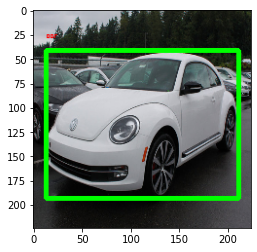

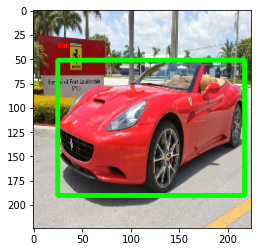

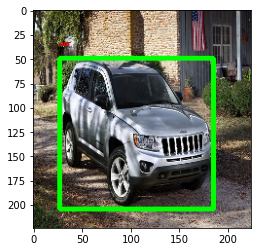

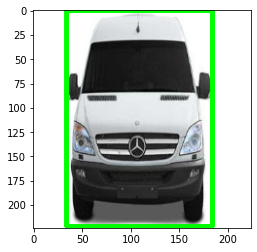

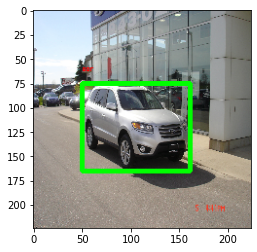

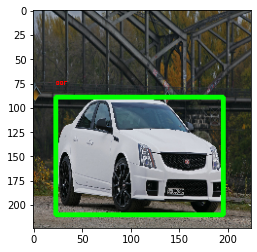

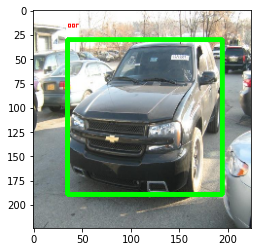

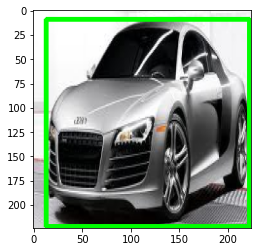

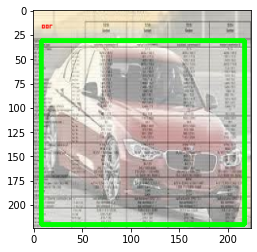

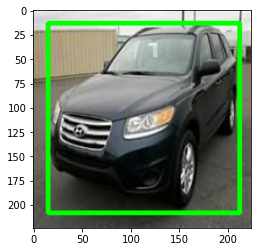

In [ ]:
from axelerate.networks.common_utils.augment import visualize_detection_dataset

visualize_detection_dataset(img_folder='standford_cars_detection/imgs_validation', ann_folder='standford_cars_detection/anns_validation', num_imgs=10, img_size=224, augment=False)

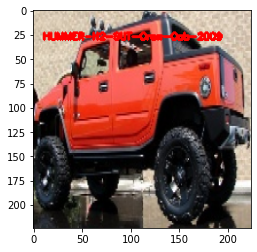

standford_cars_classification/imgs_validation/HUMMER-H2-SUT-Crew-Cab-2009/010347.jpg


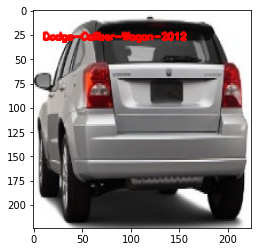

standford_cars_classification/imgs_validation/Dodge-Caliber-Wagon-2012/006730.jpg


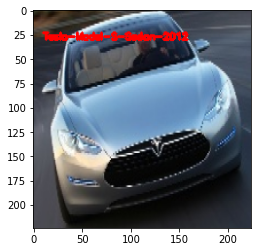

standford_cars_classification/imgs_validation/Tesla-Model-S-Sedan-2012/015248.jpg


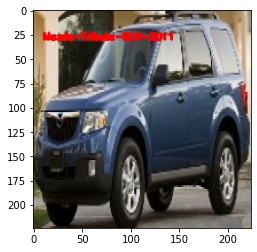

standford_cars_classification/imgs_validation/Mazda-Tribute-SUV-2011/013006.jpg


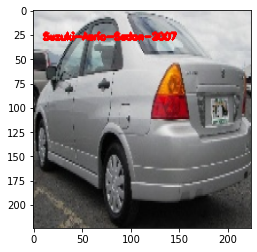

standford_cars_classification/imgs_validation/Suzuki-Aerio-Sedan-2007/014887.jpg


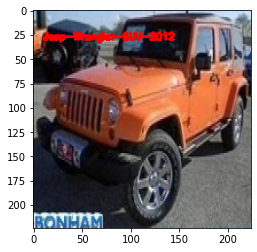

standford_cars_classification/imgs_validation/Jeep-Wrangler-SUV-2012/011982.jpg


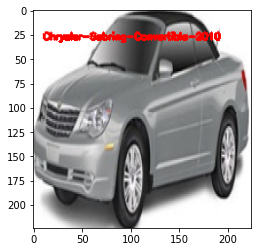

standford_cars_classification/imgs_validation/Chrysler-Sebring-Convertible-2010/006244.jpg


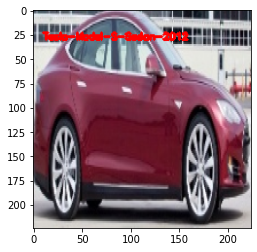

standford_cars_classification/imgs_validation/Tesla-Model-S-Sedan-2012/015223.jpg


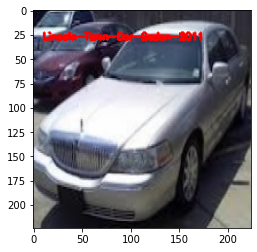

standford_cars_classification/imgs_validation/Lincoln-Town-Car-Sedan-2011/012839.jpg


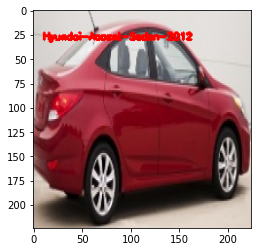

standford_cars_classification/imgs_validation/Hyundai-Accent-Sedan-2012/011187.jpg


In [ ]:
from axelerate.networks.common_utils.augment import visualize_classification_dataset

visualize_classification_dataset(img_folder='standford_cars_classification/imgs_validation', num_imgs=10, img_size=224, augment=False)

First, we're going to train a detection model. For that we need to define a config dictionary, containing parameters for model training. Most lines are self-explanatory.

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- Full Yolo
- Tiny Yolo
- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 
- SqueezeNet
- NASNetMobile
- DenseNet121
- ResNet50

For more information on anchors, please read here
https://github.com/pjreddie/darknet/issues/568

Labels are labels present in your dataset.
IMPORTANT: Please, list all the labels present in the dataset.

object_scale determines how much to penalize wrong prediction of confidence of object predictors

no_object_scale determines how much to penalize wrong prediction of confidence of non-object predictors

coord_scale determines how much to penalize wrong position and size predictions (x, y, w, h)

class_scale determines how much to penalize wrong class prediction

For converter type you can choose the following:

'k210', 'tflite_fullint', 'tflite_dynamic', 'edgetpu', 'openvino', 'onnx'

In [ ]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet2_5",
            "input_size":           224,
            "anchors":              [[[0.76120044, 0.57155991], [0.6923348, 0.88535553], [0.47163042, 0.34163313]]],
            "labels":               ["car"],
            "obj_thresh" : 		      0.5,
            "iou_thresh" : 		      0.5,
            "coord_scale" : 		    1.0,
            "object_scale" : 		    3.0,            
            "no_object_scale" : 	  1.0
        },
        "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         10,
            "train_image_folder":   "standford_cars_detection/imgs",
            "train_annot_folder":   "standford_cars_detection/anns",
            "train_times":          1,
            "valid_image_folder":   "standford_cars_detection/imgs_validation",
            "valid_annot_folder":   "standford_cars_detection/anns_validation",
            "valid_times":          1,
            "valid_metric":         "recall",
            "batch_size":           32,
            "learning_rate":        1e-3,
            "saved_folder":   		F"/content/drive/MyDrive/vehicle_detection",
            "first_trainable_layer": "",
            "augmentation":				True,
            "is_only_detect" : 		False
        },
        "converter" : {
            "type":   				["tflite"]
        }
    }

Let's check what GPU we have been assigned in this Colab session, if any.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7109040503832121933, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16183459840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5584048002500917641
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Finally we start the training by passing config dictionary we have defined earlier to setup_training function. The training will start with Cosine Annealing Learning Rate Schedule and recall/precision metrics.Model is saved in the end of each epoch, if validation metric you specified exceeds the results of previous epoch. If you have specified the converter type in the config, after the training has stopped the script will convert the best model into the format you have specified in config and save it to the project folder.

We'll train for 10 epochs, which should be enough to get moderately good model - but feel free to train for 30-50 epochs, which will be enough for convergence.

In [ ]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /content/drive/MyDrive/vehicle_detection is created.
Tflite Converter ready
['car']
2113536/2108140 [==============================] - 0s 0us/step
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found
standford_cars_detection/anns_validation
Current training session folder is /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21


[<axelerate.networks.yolo.backend.utils.custom.Yolo_Precision object at 0x7f08d736d690>, <axelerate.networks.yolo.backend.utils.custom.Yolo_Recall object at 0x7f08d73874d0>]
Model: "yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
__

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 8)       216       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 8)       32        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 8)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 8)       72        
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 8)       32     

After training it is good to check the actual perfomance of your model by doing inference on your validation dataset and visualizing results. This is exactly what next block does. Our model used pre-trained weights and since all the layers were set as non-trainable, we are just observing the perfomance of the model that was trained before.

In [ ]:
%matplotlib inline
from keras import backend as K 
K.clear_session()
setup_evaluation(config, model_path)

Folder /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21/Evaluation_results is created.
Successfully loaded imagenet backend weights
Loading pre-trained weights for the whole model:  /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21/yolo_best_recall.h5
[[ 37  64 934 519]] [[0.9937024]]
1-boxes are detected. /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21/Evaluation_results/000001.jpg saved.
detect_idx: 0, true_idx: 0, matching-score: 0.5651463676177305
[[ 30  59 202 143]] [[0.9898609]]
1-boxes are detected. /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21/Evaluation_results/000004.jpg saved.
detect_idx: 0, true_idx: 0, matching-score: 0.8085903718650908
[[  9   1 296 176]] [[0.9985404]]
1-boxes are detected. /content/drive/MyDrive/vehicle_detection/2021-07-16_07-54-21/Evaluation_results/000013.jpg saved.
detect_idx: 0, true_idx: 0, matching-score: 0.9439106145251397
[[ 63  70 379 252]] [[0.9989217]]
1-boxes are detected. /content/drive/MyD

Now we'll use very similar procedure to train a classifier for fine-grained classification. First we define the config dictionary for classifier training.

In [ ]:
config = {
    "model" : {
        "type":                 "Classifier",
        "architecture":         "MobileNet5_0",
        "input_size":           [128, 196],
        "fully-connected":      [],
        "labels":               [],
        "dropout" : 		        0.2
    },
     "weights" : {
            "full":   				"",
            "backend":   		    "imagenet",
            "save_bottleneck":      False
        
    },
    "train" : {
        "actual_epoch":         10,
        "train_image_folder":   "standford_cars_classification/imgs",
        "train_times":          1,
        "valid_image_folder":   "standford_cars_classification/imgs_validation",
        "valid_times":          1,
        "valid_metric":         "accuracy",
        "batch_size":           32,
        "learning_rate":        1e-3,
        "saved_folder":   		F"/content/drive/MyDrive/vehicle_classifier",
        "first_trainable_layer": "",
        "augmentation":				True
    },
    "converter" : {
        "type":   				['tflite']
    }
}

Then we train the model, again for 10 epochs. 

In [ ]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /content/drive/MyDrive/vehicle_classifier already exists. Creating a folder for new training session.
Tflite Converter ready
Classifier
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found
Found 14225 images belonging to 196 classes.
AM-General-Hummer-SUV-2000
Acura-Integra-Type-R-2001
Acura-RL-Sedan-2012
Acura-TL-Sedan-2012
Acura-TL-Type-S-2008
Acura-TSX-Sedan-2012
Acura-ZDX-Hatchback-2012
Aston-Martin-V8-Vantage-Convertible-2012
Aston-Martin-V8-Vantage-Coupe-2012
Aston-Martin-Virage-Convertible-2012
Aston-Martin-Virage-Coupe-2012
Audi-100-Sedan-1994
Audi-100-Wagon-1994
Audi-A5-Coupe-2012
Audi-R8-Coupe-2012
Audi-RS-4-Convertible-2008
Audi-S4-Sedan-2007
Audi-S4-Sedan-2012
Audi-S5-Convertible-2012
Audi-S5-Coupe-2012
Audi-S6-Sedan-2011
Audi-TT-Hatchback-2011
Audi-TT-RS-Coupe-2012
Audi-TTS-Coupe-2012
Audi-V8-Sedan-1994
BMW-1-Series-Convertible-2012
B

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 196, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 198, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 98, 16)        432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 98, 16)        64        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 98, 16)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 98, 16)        144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 98, 16)        6

And evaluate it - we'll be able to see accuracy for each class and the confusion matrix.

Folder /content/drive/MyDrive/vehicle_classifier/2021-07-16_10-22-11/Evaluation_results is created.
Classifier
Loading pre-trained weights for the whole model:  /content/drive/MyDrive/vehicle_classifier/2021-07-16_10-22-11/classifier_best_accuracy.h5
Found 1960 images belonging to 196 classes.
Classification Report
                                                        precision    recall  f1-score   support

                            AM-General-Hummer-SUV-2000       0.91      1.00      0.95        10
                             Acura-Integra-Type-R-2001       0.89      0.80      0.84        10
                                   Acura-RL-Sedan-2012       0.90      0.90      0.90        10
                                   Acura-TL-Sedan-2012       0.90      0.90      0.90        10
                                  Acura-TL-Type-S-2008       0.83      1.00      0.91        10
                                  Acura-TSX-Sedan-2012       0.82      0.90      0.86        10
          

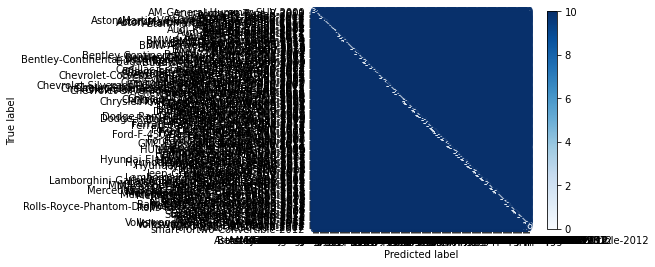

In [ ]:
%matplotlib inline
from keras import backend as K 
K.clear_session()
setup_evaluation(config, model_path)

Now we should have both Keras .h5 models and converted .tflite models in each project's respective folder. For inference on reTerminal/Raspberry Pi/any other Linux-based development board, see this example script in Seeed Studio Python Machine Learning Repository.
After installing dependencies on the target device, you'll be able to benchmark the model pipeline with a video by executing 

```python3 multi_stage_file.py --first_stage yolo_best_recall.tflite --second_stage classifier_best_accuracy.tflite --labels labels.txt  --file ../../sample_files/cars.mp4```

and run inference on video stream from camera with

```python3 multi_stage_stream.py --first_stage yolo_best_recall.tflite --second_stage classifier_best_accuracy.tflite --labels labels.txt```